In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt

from src.data.data_collector import DataCollector
from src.models.model_trainer_rl_v2 import ModelTrainerRL, TradingEnvRL
from src.models.backtester import PortfolioBacktester
from src.utils.config_loader import load_config

In [10]:
collector = DataCollector(symbols=['AMZN'], start_date='2024-01-01', end_date='2025-10-31', interval='1h')
collector.download_data()          # fetches data into collector.data
raw_df = collector.data['AMZN']    # raw dataframe
data = collector.prepare_data('AMZN')  # with indicators and labels
data.to_csv(f'data/processed/AMZN_processed_1h.csv', index=True)
# data.head()

INFO:src.data.data_collector:Downloading data for 1 symbols...
INFO:src.data.data_collector:Downloading AMZN...
INFO:src.data.data_collector:Downloaded 3204 records for AMZN
INFO:src.data.data_collector:Prepared 3150 records for AMZN


In [8]:
collector = DataCollector(symbols=['BKH'], start_date='2022-01-01', end_date='2025-11-30', interval='1d')
collector.download_data()          # fetches data into collector.data
raw_df = collector.data['BKH']    # raw dataframe
data = collector.prepare_data('BKH')  # with indicators and labels
data.to_csv(f'data/processed/BKH_processed_2022.csv', index=True)
# data.head()

INFO:src.data.data_collector:Downloading data for 1 symbols...
INFO:src.data.data_collector:Downloading BKH...
INFO:src.data.data_collector:Downloaded 981 records for BKH
INFO:src.data.data_collector:Prepared 927 records for BKH


In [7]:
collector = DataCollector(symbols=['MDU'], start_date='2016-01-01', end_date='2025-10-31', interval='1d')
collector.download_data()          # fetches data into collector.data
raw_df = collector.data['MDU']    # raw dataframe
data = collector.prepare_data('MDU')  # with indicators and labels
data.to_csv(f'data/processed/MDU_processed.csv', index=True)
# data.head()

INFO:src.data.data_collector:Downloading data for 1 symbols...
INFO:src.data.data_collector:Downloading MDU...
INFO:src.data.data_collector:Downloaded 2472 records for MDU
INFO:src.data.data_collector:Prepared 2418 records for MDU


In [2]:
#read csv from data/processed/AAPL_processed.csv
data = pd.read_csv('data/processed/AAPL_processed.csv')
config = load_config("config/config.yaml")
# trainer_rl = ModelTrainerRL(config['reinforcement_learning'])
# trained_agent = trainer_rl.train_agent(data)
# backtester = PortfolioBacktester(config['strategy'])
# backtest_results = backtester.backtest_strategy_rl(data=data, agent=trained_agent)
# print(backtest_results)

In [1]:
import pandas as pd
import numpy as np
from src.utils.config_loader import load_config
from src.models.model_trainer_rl import ModelTrainerRL as RLTrainer
from src.models.backtester import PortfolioBacktester
import matplotlib.pyplot as plt

# Load data and config
df = pd.read_csv('data/processed/AAPL_processed.csv')
config = load_config("config/config.yaml")
rl_cfg = config['reinforcement_learning']

# Train/test split
test_size = rl_cfg.get("test_size", 0.2)
split_idx = int(len(df) * (1 - test_size))
df_train, df_test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

print(f"Training set: {len(df_train)} samples")
print(f"Test set: {len(df_test)} samples")

# Prepare RL environments
trainer_rl = RLTrainer(rl_cfg)
env_train, env_test = trainer_rl.prepare_environment(
    df_train=df_train,
    df_test=df_test,
    reward_func=rl_cfg["environment"].get("reward_function", "sharpe"),
)

# Select and train one algorithm
algo = rl_cfg["algorithms"][0]
print(f"\nTraining {algo.upper()} agent...")

if algo == "ppo":
    train_result = trainer_rl.train_ppo(env_train)
elif algo == "a2c":
    train_result = trainer_rl.train_a2c(env_train)
elif algo == "ddpg":
    train_result = trainer_rl.train_ddpg(env_train)
elif algo == "td3":
    train_result = trainer_rl.train_td3(env_train)
elif algo == "sac":
    train_result = trainer_rl.train_sac(env_train)
else:
    raise ValueError(f"Unsupported RL algo: {algo}")

trained_agent = train_result["model"]
print("Training complete!")


# ===== BACKTEST WITH RL AGENT =====
print("\nRunning backtest with RL agent...")

# Get predictions from RL agent on test data
obs, _ = env_test.reset()
predictions = []
done = False

while not done:
    action, _ = trained_agent.predict(obs, deterministic=True)
    predictions.append(action[0])  # Extract scalar from array
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated

predictions = np.array(predictions)
print(f"Generated {len(predictions)} predictions")
print(f"Test set length: {len(df_test)}")
print(f"Action range: [{predictions.min():.3f}, {predictions.max():.3f}]")
print(f"Action mean: {predictions.mean():.3f}, std: {predictions.std():.3f}")

# Initialize backtester
backtester = PortfolioBacktester(config['strategy'])

# Reset df_test to match predictions length
df_test_subset = df_test.reset_index(drop=True).iloc[:len(predictions)].copy()

# Convert continuous actions [-1, 1] to discrete signals [0, 1, 2]
# -1 to -0.33 = Sell (0)
# -0.33 to 0.33 = Hold (1)
# 0.33 to 1 = Buy (2)
discrete_signals = np.zeros(len(predictions), dtype=int)
discrete_signals[predictions > 0.33] = 2   # Buy
discrete_signals[predictions < -0.33] = 0  # Sell
discrete_signals[(predictions >= -0.33) & (predictions <= 0.33)] = 1  # Hold

print(f"\nSignal distribution:")
print(f"  Buy (2): {(discrete_signals == 2).sum()} ({(discrete_signals == 2).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Hold (1): {(discrete_signals == 1).sum()} ({(discrete_signals == 1).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Sell (0): {(discrete_signals == 0).sum()} ({(discrete_signals == 0).sum() / len(discrete_signals) * 100:.1f}%)")

# Create signals DataFrame
signals_df = pd.DataFrame(index=df_test_subset.index)
signals_df['entries'] = discrete_signals == 2
signals_df['exits'] = discrete_signals == 0

print(f"\nGenerated {signals_df['entries'].sum()} entry signals")
print(f"Generated {signals_df['exits'].sum()} exit signals")

# Run backtest
initial_capital = config['strategy'].get('initial_capital', 100000)
commission = config['strategy'].get('commission', 0.001)

# Use the correct column name
price_column = 'close' if 'close' in df_test_subset.columns else 'Close'

portfolio = backtester.run_backtest(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    entries=signals_df['entries'],
    exits=signals_df['exits'],
    initial_capital=initial_capital,
    commission=commission
)

# Get results
metrics = backtester.get_performance_metrics()
comparison = backtester.compare_with_buy_and_hold(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    initial_capital=initial_capital
)

# Display results
print("\n" + "="*50)
print("BACKTEST RESULTS")
print("="*50)
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*50)
print("STRATEGY vs BUY & HOLD")
print("="*50)
for key, value in comparison.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Save the trained model
model_path = f"models/{algo}_agent_AAPL.zip"
trained_agent.save(model_path)
print(f"\nModel saved to {model_path}")

INFO:src.models.model_trainer_rl:Prepared training env with 1934 steps
INFO:src.models.model_trainer_rl:Prepared testing env with 484 steps


Training set: 1934 samples
Test set: 484 samples

Training PPO agent...


d:\MSDS\buy-sell-hold-strategy-prediction\venv-3.11\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning:

In the future `np.object` will be defined as the corresponding NumPy scalar.

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
INFO:src.models.model_trainer_rl:Training PPO for 200000 timesteps
INFO:src.models.backtester:Running backtest...


Training complete!

Running backtest with RL agent...
Generated 453 predictions
Test set length: 484
Action range: [0.456, 0.757]
Action mean: 0.602, std: 0.084

Signal distribution:
  Buy (2): 453 (100.0%)
  Hold (1): 0 (0.0%)
  Sell (0): 0 (0.0%)

Generated 453 entry signals
Generated 0 exit signals


INFO:src.models.backtester:Backtest completed
INFO:src.models.backtester:Performance Metrics:
INFO:src.models.backtester:  total_return: 0.20449990488852984
INFO:src.models.backtester:  annual_return: 0.16174070832124654
INFO:src.models.backtester:  sharpe_ratio: 0.6062348850344802
INFO:src.models.backtester:  max_drawdown: -0.3336052279512085
INFO:src.models.backtester:  win_rate: 1.0
INFO:src.models.backtester:  total_trades: 1
INFO:src.models.backtester:  final_value: 120449.99048885299
INFO:src.models.backtester:  profit_factor: inf
INFO:src.models.backtester:Strategy Return: 20.45%
INFO:src.models.backtester:Buy & Hold Return: 20.57%
INFO:src.models.backtester:Outperformance: -0.12%



BACKTEST RESULTS
total_return: 0.2045
annual_return: 0.1617
sharpe_ratio: 0.6062
max_drawdown: -0.3336
win_rate: 1.0000
total_trades: 1
final_value: 120449.9905
profit_factor: inf

STRATEGY vs BUY & HOLD
strategy_return: 0.2045
buy_hold_return: 0.2057
strategy_final_value: 120449.9905
buy_hold_final_value: 120570.4405
outperformance: -0.0012

Model saved to models/ppo_agent_AAPL.zip


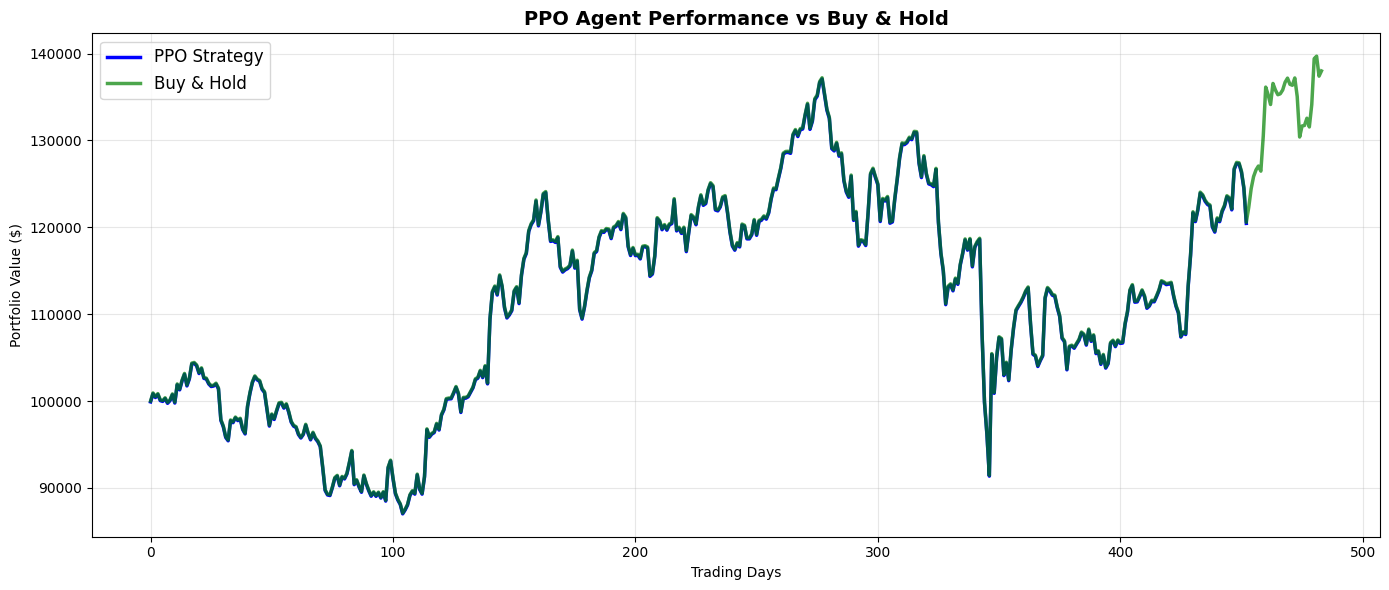

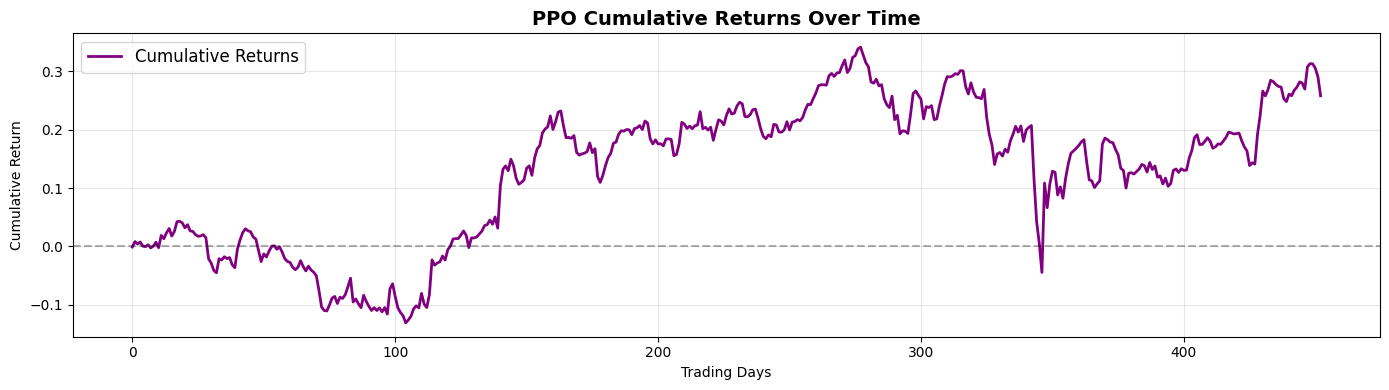

In [2]:
# Visualize backtest performance
portfolio_values = backtester.get_portfolio_value().values
price_data = df_test['close'].reset_index(drop=True).values

# Normalize buy & hold to same initial capital
initial_capital = config['strategy'].get('initial_capital', 100000)
buy_hold_values = initial_capital * (price_data / price_data[0])

plt.figure(figsize=(14, 6))
plt.plot(portfolio_values, label=f'{algo.upper()} Strategy', linewidth=2.5, color='blue')
plt.plot(buy_hold_values, label='Buy & Hold', linewidth=2.5, color='green', alpha=0.7)
plt.title(f'{algo.upper()} Agent Performance vs Buy & Hold', fontsize=14, fontweight='bold')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot returns over time
returns = backtester.get_returns().values
plt.figure(figsize=(14, 4))
plt.plot(returns.cumsum(), label='Cumulative Returns', linewidth=2, color='purple')
plt.title(f'{algo.upper()} Cumulative Returns Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
portfolio.plot().show()

## 2 a2c

In [4]:
import pandas as pd
import numpy as np
from src.utils.config_loader import load_config
from src.models.model_trainer_rl import ModelTrainerRL as RLTrainer
from src.models.backtester import PortfolioBacktester
import matplotlib.pyplot as plt

# Load data and config
df = pd.read_csv('data/processed/AAPL_processed.csv')
config = load_config("config/config.yaml")
rl_cfg = config['reinforcement_learning']

# Train/test split
test_size = rl_cfg.get("test_size", 0.2)
split_idx = int(len(df) * (1 - test_size))
df_train, df_test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

print(f"Training set: {len(df_train)} samples")
print(f"Test set: {len(df_test)} samples")

# Prepare RL environments
trainer_rl = RLTrainer(rl_cfg)
env_train, env_test = trainer_rl.prepare_environment(
    df_train=df_train,
    df_test=df_test,
    reward_func=rl_cfg["environment"].get("reward_function", "sharpe"),
)

# Select and train one algorithm
algo = rl_cfg["algorithms"][1]
print(f"\nTraining {algo.upper()} agent...")

if algo == "ppo":
    train_result = trainer_rl.train_ppo(env_train)
elif algo == "a2c":
    train_result = trainer_rl.train_a2c(env_train)
elif algo == "ddpg":
    train_result = trainer_rl.train_ddpg(env_train)
elif algo == "td3":
    train_result = trainer_rl.train_td3(env_train)
elif algo == "sac":
    train_result = trainer_rl.train_sac(env_train)
else:
    raise ValueError(f"Unsupported RL algo: {algo}")

trained_agent = train_result["model"]
print("Training complete!")


# ===== BACKTEST WITH RL AGENT =====
print("\nRunning backtest with RL agent...")

# Get predictions from RL agent on test data
obs, _ = env_test.reset()
predictions = []
done = False

while not done:
    action, _ = trained_agent.predict(obs, deterministic=True)
    predictions.append(action[0])  # Extract scalar from array
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated

predictions = np.array(predictions)
print(f"Generated {len(predictions)} predictions")
print(f"Test set length: {len(df_test)}")
print(f"Action range: [{predictions.min():.3f}, {predictions.max():.3f}]")
print(f"Action mean: {predictions.mean():.3f}, std: {predictions.std():.3f}")

# Initialize backtester
backtester = PortfolioBacktester(config['strategy'])

# Reset df_test to match predictions length
df_test_subset = df_test.reset_index(drop=True).iloc[:len(predictions)].copy()

# Convert continuous actions [-1, 1] to discrete signals [0, 1, 2]
# -1 to -0.33 = Sell (0)
# -0.33 to 0.33 = Hold (1)
# 0.33 to 1 = Buy (2)
discrete_signals = np.zeros(len(predictions), dtype=int)
discrete_signals[predictions > 0.33] = 2   # Buy
discrete_signals[predictions < -0.33] = 0  # Sell
discrete_signals[(predictions >= -0.33) & (predictions <= 0.33)] = 1  # Hold

print(f"\nSignal distribution:")
print(f"  Buy (2): {(discrete_signals == 2).sum()} ({(discrete_signals == 2).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Hold (1): {(discrete_signals == 1).sum()} ({(discrete_signals == 1).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Sell (0): {(discrete_signals == 0).sum()} ({(discrete_signals == 0).sum() / len(discrete_signals) * 100:.1f}%)")

# Create signals DataFrame
signals_df = pd.DataFrame(index=df_test_subset.index)
signals_df['entries'] = discrete_signals == 2
signals_df['exits'] = discrete_signals == 0

print(f"\nGenerated {signals_df['entries'].sum()} entry signals")
print(f"Generated {signals_df['exits'].sum()} exit signals")

# Run backtest
initial_capital = config['strategy'].get('initial_capital', 100000)
commission = config['strategy'].get('commission', 0.001)

# Use the correct column name
price_column = 'close' if 'close' in df_test_subset.columns else 'Close'

portfolio = backtester.run_backtest(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    entries=signals_df['entries'],
    exits=signals_df['exits'],
    initial_capital=initial_capital,
    commission=commission
)

# Get results
metrics = backtester.get_performance_metrics()
comparison = backtester.compare_with_buy_and_hold(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    initial_capital=initial_capital
)

# Display results
print("\n" + "="*50)
print("BACKTEST RESULTS")
print("="*50)
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*50)
print("STRATEGY vs BUY & HOLD")
print("="*50)
for key, value in comparison.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Save the trained model
model_path = f"models/{algo}_agent_AAPL.zip"
trained_agent.save(model_path)
print(f"\nModel saved to {model_path}")

INFO:src.models.model_trainer_rl:Prepared training env with 1934 steps
INFO:src.models.model_trainer_rl:Prepared testing env with 484 steps
INFO:src.models.model_trainer_rl:Training A2C for 50000 timesteps


Training set: 1934 samples
Test set: 484 samples

Training A2C agent...


INFO:src.models.backtester:Running backtest...
INFO:src.models.backtester:Backtest completed
INFO:src.models.backtester:Performance Metrics:
INFO:src.models.backtester:  total_return: 0.0
INFO:src.models.backtester:  annual_return: 0.0
INFO:src.models.backtester:  sharpe_ratio: inf
INFO:src.models.backtester:  max_drawdown: 0.0
INFO:src.models.backtester:  win_rate: nan
INFO:src.models.backtester:  total_trades: 0
INFO:src.models.backtester:  final_value: 100000.0
INFO:src.models.backtester:  profit_factor: nan
INFO:src.models.backtester:Strategy Return: 0.00%
INFO:src.models.backtester:Buy & Hold Return: 20.57%
INFO:src.models.backtester:Outperformance: -20.57%


Training complete!

Running backtest with RL agent...
Generated 453 predictions
Test set length: 484
Action range: [-1.000, -1.000]
Action mean: -1.000, std: 0.000

Signal distribution:
  Buy (2): 0 (0.0%)
  Hold (1): 0 (0.0%)
  Sell (0): 453 (100.0%)

Generated 0 entry signals
Generated 453 exit signals

BACKTEST RESULTS
total_return: 0.0000
annual_return: 0.0000
sharpe_ratio: inf
max_drawdown: 0.0000
win_rate: nan
total_trades: 0
final_value: 100000.0000
profit_factor: nan

STRATEGY vs BUY & HOLD
strategy_return: 0.0000
buy_hold_return: 0.2057
strategy_final_value: 100000.0000
buy_hold_final_value: 120570.4405
outperformance: -0.2057

Model saved to models/a2c_agent_AAPL.zip


In [3]:
import pandas as pd
import numpy as np
from src.utils.config_loader import load_config
from src.models.model_trainer_rl import ModelTrainerRL as RLTrainer
from src.models.backtester import PortfolioBacktester
import matplotlib.pyplot as plt

# Load data and config
df = pd.read_csv('data/processed/AAPL_processed.csv')
config = load_config("config/config.yaml")
rl_cfg = config['reinforcement_learning']

# Train/test split
test_size = rl_cfg.get("test_size", 0.2)
split_idx = int(len(df) * (1 - test_size))
df_train, df_test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

print(f"Training set: {len(df_train)} samples")
print(f"Test set: {len(df_test)} samples")

# Prepare RL environments
trainer_rl = RLTrainer(rl_cfg)
env_train, env_test = trainer_rl.prepare_environment(
    df_train=df_train,
    df_test=df_test,
    reward_func=rl_cfg["environment"].get("reward_function", "sharpe"),
)

# Select and train one algorithm
algo = rl_cfg["algorithms"][2]
print(f"\nTraining {algo.upper()} agent...")

if algo == "ppo":
    train_result = trainer_rl.train_ppo(env_train)
elif algo == "a2c":
    train_result = trainer_rl.train_a2c(env_train)
elif algo == "ddpg":
    train_result = trainer_rl.train_ddpg(env_train)
elif algo == "td3":
    train_result = trainer_rl.train_td3(env_train)
elif algo == "sac":
    train_result = trainer_rl.train_sac(env_train)
else:
    raise ValueError(f"Unsupported RL algo: {algo}")

trained_agent = train_result["model"]
print("Training complete!")


# ===== BACKTEST WITH RL AGENT =====
print("\nRunning backtest with RL agent...")

# Get predictions from RL agent on test data
obs, _ = env_test.reset()
predictions = []
done = False

while not done:
    action, _ = trained_agent.predict(obs, deterministic=True)
    predictions.append(action[0])  # Extract scalar from array
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated

predictions = np.array(predictions)
print(f"Generated {len(predictions)} predictions")
print(f"Test set length: {len(df_test)}")
print(f"Action range: [{predictions.min():.3f}, {predictions.max():.3f}]")
print(f"Action mean: {predictions.mean():.3f}, std: {predictions.std():.3f}")

# Initialize backtester
backtester = PortfolioBacktester(config['strategy'])

# Reset df_test to match predictions length
df_test_subset = df_test.reset_index(drop=True).iloc[:len(predictions)].copy()

# Convert continuous actions [-1, 1] to discrete signals [0, 1, 2]
# -1 to -0.33 = Sell (0)
# -0.33 to 0.33 = Hold (1)
# 0.33 to 1 = Buy (2)
discrete_signals = np.zeros(len(predictions), dtype=int)
discrete_signals[predictions > 0.33] = 2   # Buy
discrete_signals[predictions < -0.33] = 0  # Sell
discrete_signals[(predictions >= -0.33) & (predictions <= 0.33)] = 1  # Hold

print(f"\nSignal distribution:")
print(f"  Buy (2): {(discrete_signals == 2).sum()} ({(discrete_signals == 2).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Hold (1): {(discrete_signals == 1).sum()} ({(discrete_signals == 1).sum() / len(discrete_signals) * 100:.1f}%)")
print(f"  Sell (0): {(discrete_signals == 0).sum()} ({(discrete_signals == 0).sum() / len(discrete_signals) * 100:.1f}%)")

# Create signals DataFrame
signals_df = pd.DataFrame(index=df_test_subset.index)
signals_df['entries'] = discrete_signals == 2
signals_df['exits'] = discrete_signals == 0

print(f"\nGenerated {signals_df['entries'].sum()} entry signals")
print(f"Generated {signals_df['exits'].sum()} exit signals")

# Run backtest
initial_capital = config['strategy'].get('initial_capital', 100000)
commission = config['strategy'].get('commission', 0.001)

# Use the correct column name
price_column = 'close' if 'close' in df_test_subset.columns else 'Close'

portfolio = backtester.run_backtest(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    entries=signals_df['entries'],
    exits=signals_df['exits'],
    initial_capital=initial_capital,
    commission=commission
)

# Get results
metrics = backtester.get_performance_metrics()
comparison = backtester.compare_with_buy_and_hold(
    price_data=df_test_subset[price_column].reset_index(drop=True),
    initial_capital=initial_capital
)

# Display results
print("\n" + "="*50)
print("BACKTEST RESULTS")
print("="*50)
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*50)
print("STRATEGY vs BUY & HOLD")
print("="*50)
for key, value in comparison.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Save the trained model
model_path = f"models/{algo}_agent_AAPL.zip"
trained_agent.save(model_path)
print(f"\nModel saved to {model_path}")

INFO:src.models.model_trainer_rl:Prepared training env with 1934 steps
INFO:src.models.model_trainer_rl:Prepared testing env with 484 steps


Training set: 1934 samples
Test set: 484 samples

Training DDPG agent...


d:\MSDS\buy-sell-hold-strategy-prediction\venv-3.11\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning:

In the future `np.object` will be defined as the corresponding NumPy scalar.

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
INFO:src.models.model_trainer_rl:Training DDPG for 100000 timesteps
INFO:src.models.backtester:Running backtest...


Training complete!

Running backtest with RL agent...
Generated 453 predictions
Test set length: 484
Action range: [-1.000, -1.000]
Action mean: -1.000, std: 0.000

Signal distribution:
  Buy (2): 0 (0.0%)
  Hold (1): 0 (0.0%)
  Sell (0): 453 (100.0%)

Generated 0 entry signals
Generated 453 exit signals


INFO:src.models.backtester:Backtest completed
INFO:src.models.backtester:Performance Metrics:
INFO:src.models.backtester:  total_return: 0.0
INFO:src.models.backtester:  annual_return: 0.0
INFO:src.models.backtester:  sharpe_ratio: inf
INFO:src.models.backtester:  max_drawdown: 0.0
INFO:src.models.backtester:  win_rate: nan
INFO:src.models.backtester:  total_trades: 0
INFO:src.models.backtester:  final_value: 100000.0
INFO:src.models.backtester:  profit_factor: nan
INFO:src.models.backtester:Strategy Return: 0.00%
INFO:src.models.backtester:Buy & Hold Return: 20.57%
INFO:src.models.backtester:Outperformance: -20.57%



BACKTEST RESULTS
total_return: 0.0000
annual_return: 0.0000
sharpe_ratio: inf
max_drawdown: 0.0000
win_rate: nan
total_trades: 0
final_value: 100000.0000
profit_factor: nan

STRATEGY vs BUY & HOLD
strategy_return: 0.0000
buy_hold_return: 0.2057
strategy_final_value: 100000.0000
buy_hold_final_value: 120570.4405
outperformance: -0.2057

Model saved to models/ddpg_agent_AAPL.zip


### -------

In [ ]:
import pandas as pd
import numpy as np
import yaml
import logging
from stable_baselines3.common.vec_env import DummyVecEnv

# Import your custom classes
# (Assuming they are in files named model_trainer_rl.py and portfolio_backtester_rl.py)
from model_trainer_rl import ModelTrainerRL, TradingEnvRL
from portfolio_backtester_rl import PortfolioBacktesterRL

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("Main")

def load_config(path: str):
    with open(path, 'r') as file:
        return yaml.safe_load(file)

def get_agent_predictions(model, env: TradingEnvRL) -> np.ndarray:
    """
    The Bridge: Runs the trained Agent through the Test Environment 
    to record the specific actions (target weights) it takes.
    """
    logger.info("Generating predictions from trained agent...")
    
    # 1. Reset Environment
    obs, _ = env.reset()
    done = False
    
    actions = []
    
    # 2. Step-by-Step Inference Loop
    # We must run this loop because RL is state-dependent. 
    # The action at step T depends on the portfolio state at step T-1.
    while not done:
        # predict returns (action, state). We only need action.
        # deterministic=True is standard for backtesting (removes random noise)
        action, _ = model.predict(obs, deterministic=True)
        
        # Store the target weight (the action)
        actions.append(action[0])
        
        # Step the environment forward
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
    return np.array(actions)

def main():
    # --- 1. Setup ---
    logger.info("1. Loading Data and Config")
    config = load_config("config/config.yaml")
    
    # Load processed data
    df = pd.read_csv('data/processed/AAPL_processed.csv')
    
    # Ensure date is datetime and set as index (helper for vectorbt plotting later)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
    
    # --- 2. Train RL Model ---
    logger.info("2. Initializing Trainer")
    trainer = ModelTrainerRL(config)
    
    # Train models (PPO, A2C, etc.)
    # Note: We split data inside train_all, usually 80% train / 20% test
    results = trainer.train_all(df, test_size=0.2)
    
    # Get the best model (e.g., PPO)
    best_model_name = trainer.best_model_name
    best_model = trainer.best_model
    logger.info(f"Selected Best Model: {best_model_name}")
    
    # --- 3. Prepare Test Data for Backtest ---
    # We must re-create the exact environment used for testing
    # to ensure our predictions match the timeline.
    split_idx = int(len(df) * (1 - 0.2))
    df_test = df.iloc[split_idx:].copy()
    
    # Initialize the Test Environment specifically for prediction
    env_test = TradingEnvRL(
        df_test, 
        initial_balance=config['environment']['initial_balance'],
        commission=config['environment']['commission'],
        lookback_window=config['environment']['lookback_window']
    )
    
    # --- 4. Generate Predictions (The Bridge) ---
    # Run the agent over df_test to get the list of target weights
    predicted_weights = get_agent_predictions(best_model, env_test)
    
    logger.info(f"Generated {len(predicted_weights)} actions.")
    
    # --- 5. Run VectorBT Backtest ---
    logger.info("5. Running VectorBT Backtest")
    
    # Initialize our specialized RL Backtester
    backtester = PortfolioBacktesterRL(config['environment'])
    
    # Run the backtest
    # Note: We pass df_test['close'] because backtester needs raw prices
    # Note: lookback_window=30 tells it to align the data correctly
    portfolio = backtester.run_backtest(
        price_data=df_test['close'],
        predicted_weights=predicted_weights,
        lookback_window=config['environment']['lookback_window']
    )
    
    # --- 6. Results & Visualization ---
    metrics = backtester.get_performance_metrics()
    
    print("\n" + "="*30)
    print(f"FINAL RESULTS ({best_model_name})")
    print("="*30)
    for k, v in metrics.items():
        print(f"{k:<20}: {v}")
    print("="*30 + "\n")
    
    # Plotting
    # This will open a browser window or show in Jupyter
    backtester.plot_portfolio(show_orders=False)

if __name__ == "__main__":
    main()